**Business Problem**

The proliferation of hate speech on Twitter has become a significant concern, leading to various challenges, including psychological harm to users, social unrest, potential legal risks, and damage to Twitter's brand reputation. Consequently, there is a pressing need for an efficient, scalable, and accurate system to detect hate speech on the platform.


---

**Solution Description**

To address the issue of hate speech on Twitter, we developed a machine learning-based system for automatic hate speech detection. The solution involves preprocessing the text data, handling class imbalance, and building a neural network model using TensorFlow/Keras to classify the tweets.

1. **Data Collection and Preprocessing**:
   - **Dataset**: Labeled tweets are categorized into hate speech and not hate speech.
   - **Data Cleaning**: Removing missing values, expanding contractions, decoding HTML entities, converting emojis to text, and normalizing text.
   - **Text Normalization**: Converting text to lowercase, expanding abbreviations, removing URLs, mentions, hashtags, special characters, and extra spaces.
   - **Tokenization and Lemmatization**: Tokenizing and lemmatizing text to standardize words, removing stopwords.

2. **Handling Class Imbalance**:
   - **Oversampling**: Using RandomOverSampler to balance classes in the training set by oversampling the minority class.

3. **Feature Extraction**:
   - **TF-IDF Vectorization**: Converting text data into numerical features using TF-IDF vectorizer.

4. **Model Development**:
   - **Neural Network Architecture**: Building a Sequential model with multiple Dense layers, Dropout, and L2 regularization. The architecture includes:
     - Input layer with 256 units and ReLU activation.
     - Two hidden layers with 256 units each, ReLU activation, and Dropout.
     - One hidden layer with 32 units, ReLU activation, and Dropout.
     - Output layer with softmax activation for classification.

5. **Training and Optimization**:
   - **Compilation**: Compiling the model using the Adam optimizer with a learning rate of 0.00001 and the categorical cross-entropy loss function.
   - **Early Stopping**: Implementing early stopping to monitor validation loss and stop training when performance ceases to improve.

6. **Evaluation and Results**:
   - **Model Evaluation**: Evaluating the model on a test set, achieving satisfactory accuracy. Generating a classification report and confusion matrix to assess performance.
   - **Visualization**: Plotting training and validation accuracy and loss to visualize the learning process.

7. **Deployment and Prediction**:
   - **Model Deployment**: Saving the trained model for future use.
   - **Test Cases**: Preprocessing and using test cases to demonstrate the model's prediction capability, classifying text as either hate speech or not hate speech.

---

Dataset Description

The dataset used for this project contains labeled tweets, each categorized into one of three classes: hate speech, offensive language, and neutral speech. For the purpose of this solution, we focus on a binary classification problem, re-categorizing the labels into two classes: hate speech and not hate speech.

Columns:

tweet: The text content of the tweet.

hate_speech: Indicator for hate speech (binary).

offensive_language: Indicator for offensive language (binary).

neither: Indicator for neutral speech (binary).

class: Original class label (0: neither, 1: offensive language, 2: hate speech).


In [ ]:
# Install necessary packages
!pip install emoji contractions imblearn

# Import libraries
import nltk
import pandas as pd
import re
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import html
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the dataset
df = pd.read_csv('/content/labeled_dataset.csv')

# Display dataset info
print("First few rows of the dataset:")
print(df.head())
print("Shape of the dataset:")
print(df.shape)
print("\nSummary statistics for numerical columns:")
print(df.describe())


# Drop rows with missing 'tweet' values
df = df.dropna(subset=['tweet'])

# Verify missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

First few rows of the dataset:
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
Shape of the dataset:
(24783, 7)

Summary statistics for numerical columns:
         Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000      

In [ ]:
# Define abbreviations dictionary
abbreviations = {
    "$": "dollar",
    "€": "euro",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3": "anytime anywhere anyplace",
    "aamof": "as a matter of fact",
    "acct": "account",
    "adih": "another day in hell",
    "afaic": "as far as i am concerned",
    "afaict": "as far as i can tell",
    "afaik": "as far as i know",
    "afair": "as far as i remember",
    "afk": "away from keyboard",
    "app": "application",
    "approx": "approximately",
    "apps": "applications",
    "asap": "as soon as possible",
    "asl": "age sex location",
    "atk": "at the keyboard",
    "ave.": "avenue",
    "aymm": "are you my mother",
    "ayor": "at your own risk",
    "b&b": "bed and breakfast",
    "b+b": "bed and breakfast",
    "b.c": "before christ",
    "b2b": "business to business",
    "b2c": "business to customer",
    "b4": "before",
    "b4n": "bye for now",
    "b@u": "back at you",
    "bae": "before anyone else",
    "bak": "back at keyboard",
    "bbbg": "bye bye be good",
    "bbc": "british broadcasting corporation",
    "bbias": "be back in a second",
    "bbl": "be back later",
    "bbs": "be back soon",
    "be4": "before",
    "bfn": "bye for now",
    "blvd": "boulevard",
    "bout": "about",
    "brb": "be right back",
    "bros": "brothers",
    "brt": "be right there",
    "bsaaw": "big smile and a wink",
    "btw": "by the way",
    "bwl": "bursting with laughter",
    "c/o": "care of",
    "cet": "central european time",
    "cf": "compare",
    "cia": "central intelligence agency",
    "csl": "cannot stop laughing",
    "cu": "see you",
    "cul8r": "see you later",
    "cv": "curriculum vitae",
    "cwot": "complete waste of time",
    "cya": "see you",
    "cyt": "see you tomorrow",
    "dae": "does anyone else",
    "dbmib": "do not bother me i am busy",
    "diy": "do it yourself",
    "dm": "direct message",
    "dwh": "during work hours",
    "e123": "easy as one two three",
    "eet": "eastern european time",
    "eg": "example",
    "embm": "early morning business meeting",
    "encl": "enclosed",
    "encl.": "enclosed",
    "etc": "and so on",
    "faq": "frequently asked questions",
    "fawc": "for anyone who cares",
    "fb": "facebook",
    "fc": "fingers crossed",
    "fig": "figure",
    "fimh": "forever in my heart",
    "ft.": "feet",
    "ft": "featuring",
    "ftl": "for the loss",
    "ftw": "for the win",
    "fwiw": "for what it is worth",
    "fyi": "for your information",
    "g9": "genius",
    "gahoy": "get a hold of yourself",
    "gal": "get a life",
    "gcse": "general certificate of secondary education",
    "gfn": "gone for now",
    "gg": "good game",
    "gl": "good luck",
    "glhf": "good luck have fun",
    "gmt": "greenwich mean time",
    "gmta": "great minds think alike",
    "gn": "good night",
    "g.o.a.t": "greatest of all time",
    "goat": "greatest of all time",
    "goi": "get over it",
    "gps": "global positioning system",
    "gr8": "great",
    "gratz": "congratulations",
    "gyal": "girl",
    "h&c": "hot and cold",
    "hp": "horsepower",
    "hr": "hour",
    "hrh": "his royal highness",
    "ht": "height",
    "ibrb": "i will be right back",
    "ic": "i see",
    "icq": "i seek you",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "idgadf": "i do not give a damn fuck",
    "idgaf": "i do not give a fuck",
    "idk": "i do not know",
    "ie": "that is",
    "i.e": "that is",
    "ig":"i guess",
    "ifyp": "i feel your pain",
    "IG": "instagram",
    "iirc": "if i remember correctly",
    "ilu": "i love you",
    "ily": "i love you",
    "imho": "in my humble opinion",
    "imo": "in my opinion",
    "imu": "i miss you",
    "iow": "in other words",
    "irl": "in real life",
    "j4f": "just for fun",
    "jic": "just in case",
    "jk": "just kidding",
    "jsyk": "just so you know",
    "l8r": "later",
    "lb": "pound",
    "lbs": "pounds",
    "ldr": "long distance relationship",
    "lmao": "laugh my ass off",
    "lmfao": "laugh my fucking ass off",
    "lol": "laughing out loud",
    "ltd": "limited",
    "ltns": "long time no see",
    "m8": "mate",
    "mf": "motherfucker",
    "mfs": "motherfuckers",
    "mfw": "my face when",
    "mofo": "motherfucker",
    "mph": "miles per hour",
    "mr": "mister",
    "mrw": "my reaction when",
    "ms": "miss",
    "mte": "my thoughts exactly",
    "nagi": "not a good idea",
    "nbc": "national broadcasting company",
    "nbd": "not big deal",
    "nfs": "not for sale",
    "ngl": "not going to lie",
    "nhs": "national health service",
    "nrn": "no reply necessary",
    "nsfl": "not safe for life",
    "nsfw": "not safe for work",
    "nth": "nice to have",
    "nvr": "never",
    "nyc": "new york city",
    "oc": "original content",
    "og": "original",
    "ohp": "overhead projector",
    "oic": "oh i see",
    "omdb": "over my dead body",
    "omg": "oh my god",
    "omw": "on my way",
    "p.a": "per annum",
    "plz":"please",
    "p.m": "after midday",
    "pm": "prime minister",
    "poc": "people of color",
    "pov": "point of view",
    "pp": "pages",
    "ppl": "people",
    "prw": "parents are watching",
    "ps": "postscript",
    "pt": "point",
    "ptb": "please text back",
    "pto": "please turn over",
    "qpsa": "what happens",
    "ratchet": "rude",
    "rbtl": "read between the lines",
    "rlrt": "real life retweet",
    "rofl": "rolling on the floor laughing",
    "roflol": "rolling on the floor laughing out loud",
    "rotflmao": "rolling on the floor laughing my ass off",
    "rt": "retweet",
    "rt":"retweet",
    "ru": "are you",
    "shid": "slaps head in disgust",
    "somy": "sick of me yet",
    "ruok": "are you ok",
    "sfw": "safe for work",
    "sk8": "skate",
    "smh": "shake my head",
    "sq": "square",
    "srsly": "seriously",
    "ssdd": "same stuff different day",
    "tbh": "to be honest",
    "tbs": "tablespoonful",
    "tbsp": "tablespoonful",
    "tfw": "that feeling when",
    "thks": "thank you",
    "tho": "though",
    "thx": "thank you",
    "tia": "thanks in advance",
    "til": "today i learned",
    "tl;dr": "too long i did not read",
    "tldr": "too long i did not read",
    "tmb": "tweet me back",
    "tntl": "trying not to laugh",
    "ttyl": "talk to you later",
    "u": "you",
    "u2": "you too",
    "u4e": "yours forever",
    "utc": "coordinated universal time",
    "w/": "with",
    "w/o": "without",
    "w8": "wait",
    "wassup": "what is up",
    "wb": "welcome back",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wtpa": "where the party at",
    "wuf": "where are you from",
    "wuzup": "what is up",
    "wywh": "wish you were here",
    "yd": "yard",
    "u":"you",
    "ygtr": "you got that right",
    "ynk": "you never know",
    "zzz": "sleeping bored and tired"
}

In [ ]:
# Function to replace abbreviations in text
def expand_abbreviations(text):
    words = text.split()
    expanded_words = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in words]
    return ' '.join(expanded_words)

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to decode HTML entities
def decode_html_entities(text):
    return html.unescape(text)

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to convert emojis to words
def convert_emojis_to_words(text):
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'(:\w+:)', r' \1 ', text)
    return text

# Normalize text
def normalize_text(text):
    text = text.lower()
    text = decode_html_entities(text)
    text = convert_emojis_to_words(text)
    text = expand_abbreviations(text)
    text = expand_contractions(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'&', 'and', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'(.)\1+', r'\1', text)
    return text

# Apply normalization to tweets
df['tweet'] = df['tweet'].apply(normalize_text)

# Tokenization
df['tweet_tokens'] = df['tweet'].apply(word_tokenize)

# Remove stopwords
df['tweet_tokens'] = df['tweet_tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply lemmatization
df['tweet_tokens'] = df['tweet_tokens'].apply(lemmatize_tokens)

In [ ]:
df = df[df['tweet_tokens'].str.strip().astype(bool)]

# Drop the 'count' column
df = df.drop(columns=['count'], errors='ignore')

# Verify and clean columns
df = df[[ 'class', 'tweet', 'tweet_tokens']]

# Define function to join tokens
def join_tokens(token_list):
    return ' '.join(token_list)

# Join tokens into a single string
df['merged_tweet'] = df['tweet_tokens'].apply(join_tokens)

# Remove rows with NaN values or empty strings in 'merged_tweet'
df = df.dropna(subset=['merged_tweet'])
df = df[df['merged_tweet'].str.strip() != '']

# Re-categorize the classes
df['class'] = df['class'].map({0: 0, 1: 0, 2: 1})

# Save cleaned dataset
df.to_csv('cleaned_dataset_combined.csv', index=False)

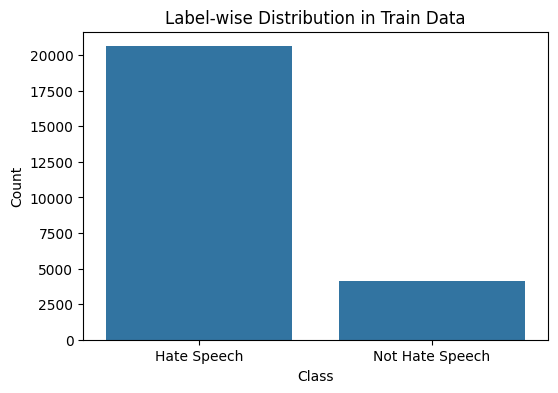

In [ ]:
# Label wise split in train data
label_counts = df['class'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label-wise Distribution in Train Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([1, 0], ['Not Hate Speech', 'Hate Speech'])
plt.show()

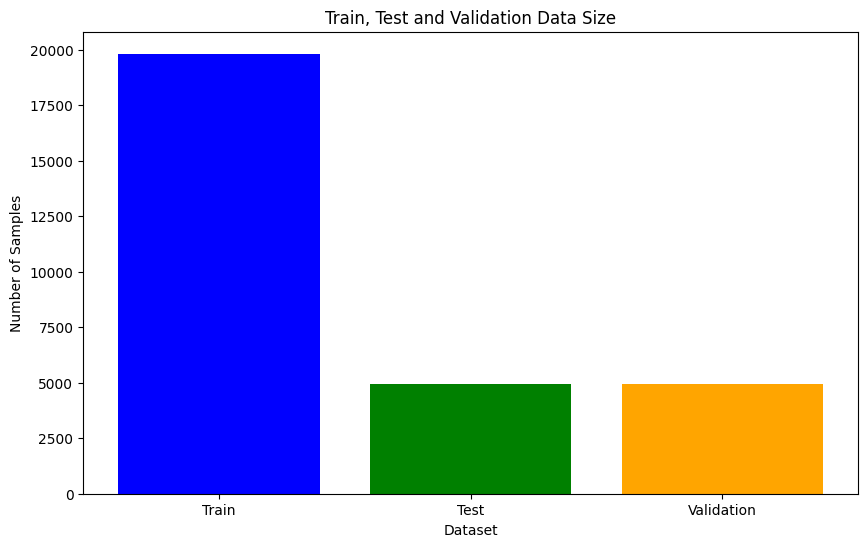

In [ ]:
# Define feature and target variables
X = df['merged_tweet']
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Visualization
# Train, Test and Validation test data size
train_size = len(X_train)
test_size = len(X_test)
validation_size = len(X_test)

plt.figure(figsize=(10, 6))
plt.bar(['Train', 'Test', 'Validation'], [train_size, test_size, validation_size], color=['blue', 'green', 'orange'])
plt.title('Train, Test and Validation Data Size')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
# Oversample the minority class in the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert the resampled data back to their original shape
X_train_resampled = X_train_resampled.flatten()

# Use TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_resampled)
X_test_tfidf = tfidf.transform(X_test)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_resampled)
y_test_one_hot = to_categorical(y_test)

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(256, input_dim=X_train_tfidf.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(df['class'].unique()), activation='softmax'))


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


# Train the model with early stopping
history = model.fit(X_train_tfidf.toarray(), y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_tfidf.toarray(), y_test_one_hot), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_one_hot)
print(f'Test set accuracy: {accuracy:.2f}')

Epoch 1/100
1030/1030 [==============================] - 12s 8ms/step - loss: 8.1578 - accuracy: 0.5135 - val_loss: 5.9311 - val_accuracy: 0.2237
Epoch 2/100
1030/1030 [==============================] - 6s 6ms/step - loss: 4.8261 - accuracy: 0.5924 - val_loss: 4.0067 - val_accuracy: 0.4986
Epoch 3/100
1030/1030 [==============================] - 6s 6ms/step - loss: 3.4838 - accuracy: 0.7042 - val_loss: 3.0452 - val_accuracy: 0.6203
Epoch 4/100
1030/1030 [==============================] - 6s 6ms/step - loss: 2.6792 - accuracy: 0.7526 - val_loss: 2.3666 - val_accuracy: 0.6926
Epoch 5/100
1030/1030 [==============================] - 6s 6ms/step - loss: 2.0728 - accuracy: 0.8176 - val_loss: 1.8403 - val_accuracy: 0.8012
Epoch 6/100
1030/1030 [==============================] - 6s 6ms/step - loss: 1.5834 - accuracy: 0.8760 - val_loss: 1.4195 - val_accuracy: 0.8676
Epoch 7/100
1030/1030 [==============================] - 7s 7ms/step - loss: 1.1795 - accuracy: 0.9167 - val_loss: 1.0504 - val_a

155/155 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4144
           1       0.79      0.94      0.86       810

    accuracy                           0.95      4954
   macro avg       0.89      0.95      0.91      4954
weighted avg       0.96      0.95      0.95      4954



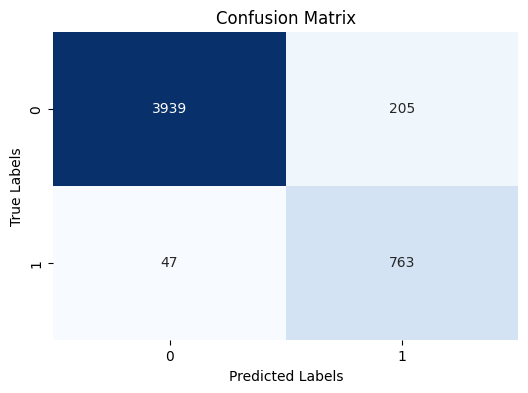

In [ ]:
# Generate classification report
y_pred = model.predict(X_test_tfidf.toarray())
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test_one_hot.argmax(axis=1)
print(classification_report(y_test_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to text_classification_model.h5


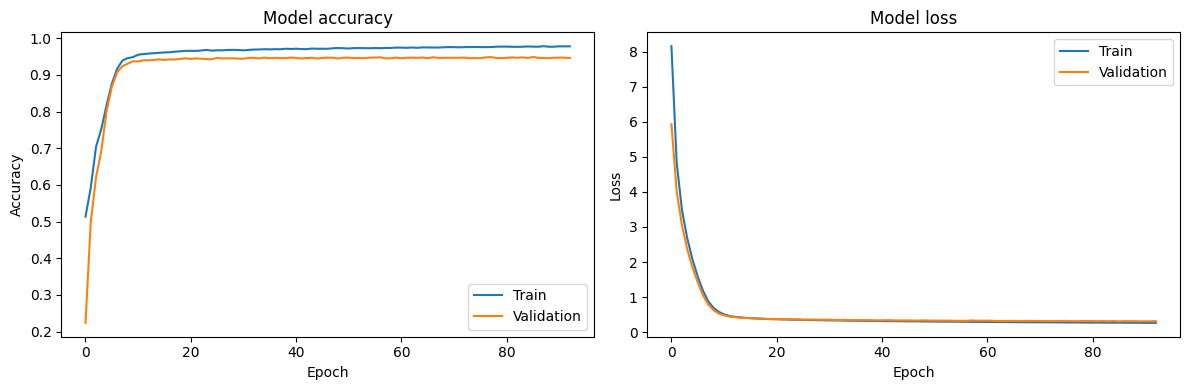

In [ ]:
# Save the model
model.save('text_classification_model.h5')


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [ ]:
# Define test cases
test_cases = [
    "#Iowa is full of white trash",
    "&#8220;@AbstractLife: @NigelDixon1 @SeanTHarrington Orton is idc&#8221; he ain't been playing. Trashlex Smith only sat out Kaep took his spot.",
    "&#8220;@G_Anderson4: I'm Dre's a bitch tho&#8221; &#128527;",
    "- Dis be heaven fo a colored man",
    "&#8220;@LakeshoreJohnny: Eliot was a pussy.&#8221; MMMMMETHER",
    "don't let your side bitch settle in, I might have to headbutt you Evelyn",

]

In [ ]:
# Preprocess test cases
def preprocess_test_cases(test_cases):
    # Normalize text
    test_cases_normalized = [normalize_text(text) for text in test_cases]
    # Tokenization
    test_cases_tokenized = [word_tokenize(text) for text in test_cases_normalized]
    # Remove stopwords
    test_cases_no_stopwords = [[word for word in tokens if word not in stop_words] for tokens in test_cases_tokenized]
    # Lemmatization
    test_cases_lemmatized = [lemmatize_tokens(tokens) for tokens in test_cases_no_stopwords]
    # Join tokens
    test_cases_joined = [' '.join(tokens) for tokens in test_cases_lemmatized]
    return test_cases_joined

# Preprocess test cases
test_cases_processed = preprocess_test_cases(test_cases)

# Use TfidfVectorizer to transform test cases
test_cases_tfidf = tfidf.transform(test_cases_processed)

# Predict classes for test cases
predictions = model.predict(test_cases_tfidf.toarray())

1/1 [==============================] - 0s 17ms/step


In [ ]:
# Decode predictions
predicted_classes = [0 if prediction.argmax() == 1 else 1 for prediction in predictions]

# Display results
for i, text in enumerate(test_cases):
    label = "Hate Speech" if predicted_classes[i] == 1 else "Not Hate Speech"
    print(f'Text: "{text}" - Predicted Label: {label}')

# Save predictions and test cases to a DataFrame
results_df = pd.DataFrame({'Text': test_cases, 'Predicted Class': predicted_classes})

Text: "#Iowa is full of white trash" - Predicted Label: Hate Speech
Text: "&#8220;@AbstractLife: @NigelDixon1 @SeanTHarrington Orton is idc&#8221; he ain't been playing. Trashlex Smith only sat out Kaep took his spot." - Predicted Label: Not Hate Speech
Text: "&#8220;@G_Anderson4: I'm Dre's a bitch tho&#8221; &#128527;" - Predicted Label: Hate Speech
Text: "- Dis be heaven fo a colored man" - Predicted Label: Not Hate Speech
Text: "&#8220;@LakeshoreJohnny: Eliot was a pussy.&#8221; MMMMMETHER" - Predicted Label: Hate Speech
Text: "don't let your side bitch settle in, I might have to headbutt you Evelyn" - Predicted Label: Hate Speech
